In [ ]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.

drive.mount('/content/drive/')
data_path = '/content/drive/Shareddrives/IR'

Mounted at /content/drive/


In [ ]:
!pip install config

In [ ]:
pip install python-igraph==0.8.3

     |████████████████████████████████| 3.2MB 12.5MB/s 


In [ ]:
pip install implicit

     |████████████████████████████████| 1.1MB 15.4MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419480 sha256=8f337c211de5f8a3ef5f3babf48fe6429467978a704340f5f9361287d659fc14
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [ ]:
pip install network

  Created wheel for network: filename=network-0.1-cp36-none-any.whl size=3155 sha256=95b82133ab9099af08ed437ad24d6aefede9dd92fc1dba4bd94ed0c46ba912cc
  Stored in directory: /root/.cache/pip/wheels/f6/e7/6a/70989d7246573ac455e33b059ed204518c33e9c276965f005f
Successfully built network


In [ ]:
from google.colab import files
uploaded = files.upload()
for file in uploaded:
  print("file name : {} , length: {}".format(file,len(file)))

from myfunctions import *

Saving myfunctions.py to myfunctions.py
file name : myfunctions.py , length: 14
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
import igraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from collections import Counter
import implicit
import networkx as nx

output_path = '/content/drive/Shareddrives/Vaya_puta_mierda/IR/outputs/'

In [ ]:
 OUTPUT_FILENAME = "/data/tweets100_hydrated.json"

 with open(data_path+OUTPUT_FILENAME, 'r') as f:
    lines = f.readlines() # read only the first tweet/line
    data = [json.loads(str_) for str_ in lines]

In [ ]:
df_tweets = pd.DataFrame.from_records(data)
df_tweets["retweeted_status"]=df_tweets["retweeted_status"].apply(lambda x: 0 if str(x)=="nan" else x)

df_original = df_tweets[df_tweets["retweeted_status"]==0]
#0: tweets are not RT
#1: tweets are RT
df_original.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,possibly_sensitive,extended_entities,withheld_in_countries
1,Thu Dec 17 13:47:46 +0000 2020,1339567967223250947,1339567967223250947,Oh yr eh ohi nhi aa jine corona kr k parliamen...,False,"[0, 157]","{'hashtags': [{'text': 'FarmersProtest', 'indi...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 863024748590059521, 'id_str': '86302474...",None,None,None,None,0,True,1,7,False,False,en,1.339402e+18,1339402143866912770,"{'url': 'https://t.co/S8foPwBiKY', 'expanded':...",{'created_at': 'Thu Dec 17 02:48:50 +0000 2020...,False,NaN,NaN
4,Thu Dec 17 13:47:46 +0000 2020,1339567967613366272,1339567967613366272,@sambosnumerouno @MENnewsdesk @ccoxmenmedia Ye...,False,"[44, 322]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",1.339567e+18,1339566783964045312,9.286508e+17,928650799349161984,sambosnumerouno,"{'id': 2831341487, 'id_str': '2831341487', 'na...",None,None,None,None,0,False,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Thu Dec 17 13:47:46 +0000 2020,1339567967680475136,1339567967680475136,How about not acknowledging Covid\nThe dangers...,False,"[0, 196]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,None,NaN,None,None,"{'id': 802581205262696448, 'id_str': '80258120...",None,None,None,None,0,True,0,0,False,False,en,1.339376e+18,1339375759677411328,"{'url': 'https://t.co/ukUd8G4XQP', 'expanded':...",{'created_at': 'Thu Dec 17 01:04:00 +0000 2020...,False,NaN,NaN
8,Thu Dec 17 13:47:46 +0000 2020,1339567967718305794,1339567967718305794,fuck we really boutta be 5-9 😔 https://t.co/h8...,False,"[0, 30]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 1037829476267249664, 'id_str': '1037829...",None,None,None,None,0,True,0,1,False,False,en,1.339568e+18,1339567549768491012,"{'url': 'https://t.co/h8gTqdoBfm', 'expanded':...",{'created_at': 'Thu Dec 17 13:46:06 +0000 2020...,False,NaN,NaN
11,Thu Dec 17 13:47:46 +0000 2020,1339567968234201093,1339567968234201093,oh no 😂 https://t.co/op7jImeDRi,False,"[0, 7]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 1313181832700194818, 'id_str': '1313181...",None,None,None,None,0,True,0,0,False,False,en,1.339568e+18,1339567549768491012,"{'url': 'https://t.co/op7jImeDRi', 'expanded':...",{'created_at': 'Thu Dec 17 13:46:06 +0000 2020...,False,NaN,NaN


In [ ]:
df_retweets = df_tweets[df_tweets["full_text"].apply(lambda x: x[:2]) == "RT"]

df_graph = pd.DataFrame(columns=["source", "destination"])

# add source-nodes
df_graph["source"] = df_retweets["user"].apply(lambda x: x["screen_name"])

# add destination-nodes
df_graph["destination"] = df_retweets["retweeted_status"].apply(lambda x: x["user"]["screen_name"] if x !=0 else "Not_known")

In [ ]:
df_graph

,source,destination
0,Rabia93188764,News24
2,ArgusC,fred_guttenberg
3,ALF4Prez2020,scottlincicome
5,GayHaught1990,WynonnaEarpPod
7,weezer04664334,ShawnG927
...,...,...
146300,mtg_claybee,jbenmenachem
146301,JYgiss,AllatOnce0922
146302,ZaRdOz420WPN,DrEricDing
146303,golfmangosierra,IanDunt


In [ ]:
ids = df_graph.index[df_graph['destination'] == "Not_known"].tolist()

In [ ]:
#We drop the rows that would give some problems below and also those that are duplicates.
df_graph.drop(ids, inplace=True)
df_graph.drop_duplicates(inplace=True)

In [ ]:
#We take a smaller sample of the nodes in order to be able to run the algorithms.
df_graph = df_graph[:7000]
df_graph

,source,destination
0,Rabia93188764,News24
2,ArgusC,fred_guttenberg
3,ALF4Prez2020,scottlincicome
5,GayHaught1990,WynonnaEarpPod
7,weezer04664334,ShawnG927
...,...,...
10350,WilliamElGato3,cynthiamckinney
10352,MitziForPelosi,NicolleDWallace
10357,2020thetruthm,DigbyKale
10358,YungKakathot,TheBoyWhoWrote


In [ ]:
tweet_graph = igraph.Graph.TupleList(df_graph.itertuples(index=False), directed=False)

In [ ]:
def plot_loglog(degree_lst):
    """
    starting from a list of degrees, it plots the log-log
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # x is the degree, y the count
    degrees_distribution = Counter(degree_lst)
    
    # distinct degree 
    degrees_ = []
    # number of nodes having same degree
    count_ = []
    for d in degrees_distribution:
        
        # append both info, key and values
        degrees_.append(d)
        count_.append(degrees_distribution[d])
        
    # logarithmic scale of both axis
    x = np.log10(np.array(degrees_)+1)

    y = np.log10(np.array(count_)+1)
    
    # plot
    ax.scatter(x=x,y=y, alpha=0.5)
    
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

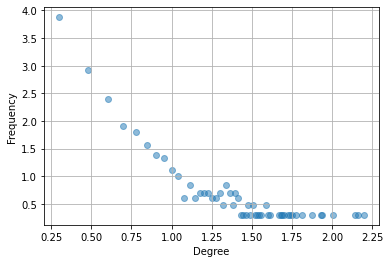

In [ ]:
plot_loglog(tweet_graph.degree())

In [ ]:
def print_top_k(graph, topk, opt, vid=None):
    """
    we print the top-k nodes with highest degree, pagerank and personalized-pagerank.
    
    Based on the selected option, a different top-k is generated
    """
    
    if opt == "degree":        
      # degree and node-idx
      deg = enumerate(graph.degree())
      
      # sorting the list "deg" by degree, extracting the top-k
      out_2 = sorted(deg, key=lambda x: x[1], reverse=True)[:topk]
      out = []
      for i in out_2:
        out.append((graph.vs.find(i[0])["name"], i[1])) 
    
    if opt == "pagerank":
        
        pr = enumerate(graph.pagerank())

        # sorting the list "pr" by pagerank, extracting the top-k

        out_2 = sorted(pr, key=lambda x: x[1], reverse=True)[:topk]
        out = []
        for i in out_2:
          out.append((graph.vs.find(i[0])["name"], i[1])) 
        

    if opt == "personalized-pr":
        
        # here we need also the argument vid, which corresponds to a node-id
        pr = enumerate(graph.personalized_pagerank(reset_vertices=vid))

        out_2 = sorted(pr, key=lambda x: x[1], reverse=True)[:topk]
        out = []
        for i in out_2:
          out.append((graph.vs.find(i[0])["name"], i[1])) 
        

    if opt == "adamic_adar":
      
      #Adamic-Adar does not work with the igraph, it works with Digraphs,
      #So in order to do it, we just pass to this type of graph.
        graph_values = []
        for edge in tweet_graph.es:
          source_vertex_id = edge.source
          target_vertex_id = edge.target
          source_vertex = tweet_graph.vs[source_vertex_id]
          target_vertex = tweet_graph.vs[target_vertex_id]
          graph_values.append([source_vertex["name"],target_vertex["name"]])
        
        graph = nx.DiGraph()
        graph.add_edges_from(graph_values)
        graph = graph.to_undirected()
        top_adamic_adar = nx.adamic_adar_index(graph)

        out = sorted(top_adamic_adar, key = lambda x: x[2],reverse=True)[:topk] 
        
    return out

In [ ]:
print(print_top_k(tweet_graph, 10, "pagerank"))
print(print_top_k(tweet_graph, 10, "degree"))
print(print_top_k(tweet_graph, 10, "personalized-pr"))

[('NicolleDWallace', 0.007447481600356267), ('JenniDigital', 0.007186639357603503), ('Emaperidol', 0.006855026480147862), ('imjustinrandall', 0.004915738414468327), ('jjamz_', 0.004430189599570675), ('BradleyWhitford', 0.004001533759442175), ('RealTina40', 0.003588888527873776), ('drdavidsamadi', 0.003221142042474303), ('JosephJFlynn1', 0.002973768597929741), ('HackBlackburn', 0.0027051973552645074)]
[('NicolleDWallace', 157), ('JenniDigital', 144), ('Emaperidol', 138), ('imjustinrandall', 100), ('jjamz_', 86), ('BradleyWhitford', 85), ('RealTina40', 74), ('drdavidsamadi', 64), ('JosephJFlynn1', 59), ('StephenKing', 55)]
[('NicolleDWallace', 0.007447481600356267), ('JenniDigital', 0.007186639357603503), ('Emaperidol', 0.006855026480147862), ('imjustinrandall', 0.004915738414468327), ('jjamz_', 0.004430189599570675), ('BradleyWhitford', 0.004001533759442175), ('RealTina40', 0.003588888527873776), ('drdavidsamadi', 0.003221142042474303), ('JosephJFlynn1', 0.002973768597929741), ('HackBla

In [ ]:
print(print_top_k(tweet_graph, 10, "adamic_adar"))

[('PalmerReport', 'NicolleDWallace', 9.300181564829556), ('imjustinrandall', 'Emaperidol', 5.238324349293728), ('FieldYates', 'MySportsUpdate', 4.32808512266689), ('imjustinrandall', 'JenniDigital', 3.7956293084047643), ('Emaperidol', 'JenniDigital', 3.6067376022224082), ('BradleyWhitford', 'NicolleDWallace', 3.263173494142638), ('DilipGhoshBJP', 'BJP4India', 2.8853900817779268), ('_princeofwales', 'Nico_Bloom', 2.8853900817779268), ('TomPelissero', 'FieldYates', 2.8853900817779268), ('KatiePavlich', 'RepAndyBiggsAZ', 2.8853900817779268)]


In [ ]:
def find_nodes_at_distance_2(graph, N):
    """
    starting from a graph this function returns all the nodes at distance 2
    N: is the number we want to extract with distance 2
    """
    

    all_potential_recommendations = set()
    
    for n1 in graph.vs:
        
        # all the nodes at distance 1
        nodes_at_most_distant_1 = set(graph.neighborhood(n1, order=1))

        # all the nodes at distance 1 and distance 2

        nodes_at_most_distant_2 = set(graph.neighborhood(n1, order=2))

        # only the nodes at distance 2
        only_nodes_at_distance_2 = nodes_at_most_distant_2 - nodes_at_most_distant_1
        
        
        # check if empty set
        if len(only_nodes_at_distance_2) > 0:
            
            for n2 in only_nodes_at_distance_2:
                
                # since n1 is an igraph vertex object, we need to extract the id
                n1_index = n1.index
                
                all_potential_recommendations.add((n1_index, n2))
            
    return all_potential_recommendations

In [ ]:
# fraction of edges to select as test-set
p = 0.2

# graphsize
N = len(tweet_graph.es)

# idxs of all the edges
all_idxs = range(N)

# sample idxs of edges through the function "choice"
test_idxs = np.random.choice(a=all_idxs, size=int(p*N),replace=False)

In [ ]:
testset = set()
trainset = set()
for idx, one_edge in enumerate(tweet_graph.es):
    
    # take n1 and n2 idx from one_edge, that is an igraph edge *object*
    n1 = one_edge.source
    n2 = one_edge.target

    if idx in test_idxs:
        
        testset.add((n1, n2, 1))
    else:
        
        trainset.add((n1, n2, 1))

In [ ]:
len(testset) 

1400

In [ ]:
train_graph = igraph.Graph.TupleList(trainset,directed=False)
all_potential_recommendations = find_nodes_at_distance_2(train_graph, len(testset))
for rec in all_potential_recommendations:
    
    # add to ground truth also the potential nodes
    n1 = rec[0]
    n2 = rec[1]
    
    testset.add((n1,n2,0))

test_graph = igraph.Graph.TupleList(testset, directed=False)

In [ ]:
def predict_ALS(testset, model):
    """
    predict for a list of observations the score for adding/removing a link
    """

    # initialize the empty list
    all_predictions = []

    # scroll the obs
    for n1,n2, w in testset:
        
        # take here the low-dimensional vectors returned by the matrix factorization
        
        array_n1 = model.user_factors[n1,:]
        array_n2 = model.item_factors[n2,:]

        # multiplying these vectors we generate an approximation for the edge score
        one_p = np.dot(array_n1, array_n2)

        all_predictions.append(one_p)
        
    return all_predictions

In [ ]:
# first we get the adjacency matrix data
M = tweet_graph.get_adjacency().data
M = csr_matrix(M)
from implicit.als import AlternatingLeastSquares as als
#Building the model
model1 = als(factors=10, calculate_training_loss=True,  iterations=5)
model1.fit(M)

# generate the predictions
df_test = pd.DataFrame(list(testset), columns=["n1","n2", "edge"])
all_predictions = predict_ALS(df_test.values, model1)

# add predictions to df
df_test["rating"] = all_predictions

df_test = df_test.sort_values('rating',ascending=False)
df_test["n1_name"] = df_test["n1"].apply(lambda x: (tweet_graph.vs.find(x)["name"]))
df_test["n2_name"] = df_test["n2"].apply(lambda x: (tweet_graph.vs.find(x)["name"]))

df_test.head(10)

GPU training requires factor size to be a multiple of 32. Increasing factors from 10 to 32.


,n1,n2,edge,rating,n1_name,n2_name
7008,1792,5699,1,1.075836,JosephJFlynn1,viettha00118981
31228,96,8549,1,1.053725,NicolleDWallace,TeresaMFrench
77352,96,4982,1,1.053416,NicolleDWallace,Ohiomom6
51500,96,4661,1,1.053244,NicolleDWallace,MaryEllenBella4
231,1792,7706,1,1.033360,JosephJFlynn1,NEWWORLDONE1
68962,158,1880,1,1.013330,Emaperidol,jsende
47003,158,373,1,1.013142,Emaperidol,romilchadha
16212,51,1538,1,1.011291,imjustinrandall,uhhm__okay
35564,160,7612,1,1.009141,BradleyWhitford,snelmes18_n
78979,19,8388,1,1.007892,RealTina40,johnsylvester5


Take the 10 top nodes of all the nodes in the test-set


In [ ]:
def compute_Jaccard(u,v, graph):
    """
    compute jaccard similarity
    """
  
    # set of neighbors of u
    outlinks_from_u = set(graph.neighbors(u))

    # set of neighbors of v
    inlinks_to_v =set(graph.neighbors(v))

    # intesection of the two sets
    num =outlinks_from_u.intersection(inlinks_to_v)
    
    # union of the two sets
    den = set(outlinks_from_u).union(inlinks_to_v)
    
    # final division
    out = len(num)/len(den)
    
    return out

In [ ]:
values= []
for edge in test_graph.es:
  source_vertex_id = edge.source
  target_vertex_id = edge.target
  source_vertex = tweet_graph.vs[source_vertex_id]
  target_vertex = tweet_graph.vs[target_vertex_id]
  values.append([source_vertex_id, source_vertex["name"], target_vertex_id, target_vertex["name"]])

print("The lenghts of the test_graph is: ", len(values))

test_Data = pd.DataFrame(values[:1000])
test_Data.head()

The lenghts of the test_graph is:  101672


,0,1,2,3
0,0,Rabia93188764,1,News24
1,2,ArgusC,3,fred_guttenberg
2,4,ALF4Prez2020,5,scottlincicome
3,6,GayHaught1990,7,WynonnaEarpPod
4,8,weezer04664334,9,ShawnG927


In [ ]:
test_dict = {}
for i in test_Data[0]:
  node_list = []
  for j in test_Data[2]:
    node_list.append([j,compute_Jaccard(i,j,test_graph)])
  test_dict[i] = node_list


In [ ]:
similarity = pd.DataFrame(test_dict)
topk = 10
output = []
for i in similarity.columns:
  order = sorted(similarity.loc[:,i], key = lambda x: x[1], reverse=True)[:topk]

  out = []
  for j in order:
    out.append((tweet_graph.vs.find(j[0])["name"], j[1]))

  output.append((tweet_graph.vs.find(i)["name"],out))


output = pd.DataFrame(output)
output.rename(columns = {0:"Nodes", 1:"Top_k"}, inplace=True)

output[["Top1", "Top2", "Top3", "Top4", "Top5","Top6","Top7","Top8","Top9","Top10"]] = pd.DataFrame(output.Top_k.tolist())
output.drop("Top_k",axis=1,inplace=True)
 
output.to_csv(output_path+"Top_k_for_each_node.csv", sep =";")                   
output

,Nodes,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10
0,Rabia93188764,"(CtiivasGp, 0.9701492537313433)","(USIP, 0.9701492537313433)","(purplediscomove, 0.9701492537313433)","(CharlyNeeners7, 0.9701492537313433)","(kakashimmy, 0.9701492537313433)","(mechtild5, 0.9701492537313433)","(TeamRubicon, 0.9701492537313433)","(Milvet2009, 0.9701492537313433)","(TeamRubicon, 0.9701492537313433)","(DamilareOE, 0.9701492537313433)"
1,ArgusC,"(fred_guttenberg, 0.8)","(YesThatInfidel, 0.8)","(ccollins43, 0.022727272727272728)","(News24, 0.0)","(scottlincicome, 0.0)","(WynonnaEarpPod, 0.0)","(ShawnG927, 0.0)","(Jeffdc5, 0.0)","(DWUhlfelderLaw, 0.0)","(ProjectLincoln, 0.0)"
2,ALF4Prez2020,"(scottlincicome, 0.95)","(DrPhillipLee, 0.95)","(GoodPoliticGuy, 0.95)","(VoBo_USA, 0.95)","(johnny5is_Alive, 0.95)","(metroDpan, 0.95)","(AllisonRebecca_, 0.95)","(robkennedy50, 0.95)","(AKippieloo, 0.95)","(CindyBlattman, 0.95)"
3,GayHaught1990,"(Nanderrs, 0.971830985915493)","(DogginTrump, 0.971830985915493)","(ChefGruel, 0.971830985915493)","(mike_roberts74, 0.971830985915493)","(irregularrogue, 0.971830985915493)","(ed4socialchange, 0.971830985915493)","(JanetGW, 0.971830985915493)","(OrenIShiKiddo, 0.971830985915493)","(hermelamelo, 0.971830985915493)","(C_Robbins_, 0.971830985915493)"
4,weezer04664334,"(ChooseNJ, 0.9918032786885246)","(ShawnG927, 0.9836065573770492)","(NycIndoor, 0.9836065573770492)","(jtLOL, 0.9836065573770492)","(AP, 0.9836065573770492)","(rafaelsalas12, 0.9836065573770492)","(buffer1974, 0.9836065573770492)","(fortpapalia, 0.9836065573770492)","(jtLOL, 0.9836065573770492)","(rjnock, 0.9836065573770492)"
...,...,...,...,...,...,...,...,...,...,...,...
656,CNN,"(CNN, 1.0)","(CtiivasGp, 0.9420289855072463)","(USIP, 0.9420289855072463)","(purplediscomove, 0.9420289855072463)","(CharlyNeeners7, 0.9420289855072463)","(kakashimmy, 0.9420289855072463)","(mechtild5, 0.9420289855072463)","(TeamRubicon, 0.9420289855072463)","(Milvet2009, 0.9420289855072463)","(TeamRubicon, 0.9420289855072463)"
657,trackntracer,"(simone_peake, 0.6666666666666666)","(News24, 0.0)","(fred_guttenberg, 0.0)","(scottlincicome, 0.0)","(WynonnaEarpPod, 0.0)","(ShawnG927, 0.0)","(Jeffdc5, 0.0)","(DWUhlfelderLaw, 0.0)","(ProjectLincoln, 0.0)","(ADLavinsky, 0.0)"
658,sophieturndaily,"(_TheCivilRight, 0.9230769230769231)","(a7medalkalbani, 0.9230769230769231)","(swinny198, 0.9230769230769231)","(ABSCBNNews, 0.8888888888888888)","(ABSCBNNews, 0.8888888888888888)","(DanceLikeLance, 0.4528301886792453)","(soulreign, 0.3870967741935484)","(BIZPACReview, 0.06666666666666667)","(JenniDigital, 0.0625)","(EishaTweets, 0.0625)"
659,emeka6010,"(emeka6010, 1.0)","(CtiivasGp, 0.9420289855072463)","(USIP, 0.9420289855072463)","(purplediscomove, 0.9420289855072463)","(CharlyNeeners7, 0.9420289855072463)","(kakashimmy, 0.9420289855072463)","(mechtild5, 0.9420289855072463)","(TeamRubicon, 0.9420289855072463)","(Milvet2009, 0.9420289855072463)","(TeamRubicon, 0.9420289855072463)"
